In [ ]:
!pip install pandas numpy matplotlib koreanize-matplotlib konlpy wheel JPype1


In [1]:
import os
import subprocess
import urllib.request
import zipfile
import sys

def update_gitignore():
    """gitignore에 Java 관련 파일들 추가 (파일이 없으면 자동 생성)"""
    gitignore_entries = [
        "# Java Runtime for KoNLPy",
        "java/",
        "openjdk-*.zip",
        "*.jdk",
        "jdk*/",
        "# Java 실행 파일",
        "java.exe",
        "javac.exe",
        "",
        "# Python",
        "__pycache__/",
        "*.pyc",
        "*.pyo",
        "*.pyd",
        ".Python",
        "*.so",
        "",
        "# Jupyter Notebook",
        ".ipynb_checkpoints",
        "",
        "# IDE",
        ".vscode/",
        ".idea/",
        "*.swp",
        "*.swo",
        "*~"
    ]
    
    try:
        # 기존 .gitignore 내용 읽기
        existing_content = ""
        gitignore_exists = os.path.exists(".gitignore")
        
        if gitignore_exists:
            try:
                with open(".gitignore", "r", encoding="utf-8") as f:
                    existing_content = f.read()
            except:
                try:
                    with open(".gitignore", "r", encoding="cp949") as f:  # Windows 기본 인코딩
                        existing_content = f.read()
                except:
                    existing_content = ""
        else:
            print("📝 .gitignore 파일이 없습니다. 새로 생성합니다.")
        
        # 이미 Java 관련 항목이 있는지 확인
        if "java/" in existing_content:
            print("✅ .gitignore에 이미 Java 관련 항목이 있습니다")
            return True
        
        # .gitignore 생성 또는 업데이트
        try:
            mode = "a" if gitignore_exists else "w"
            with open(".gitignore", mode, encoding="utf-8") as f:
                if gitignore_exists and existing_content and not existing_content.endswith('\n'):
                    f.write('\n')
                for entry in gitignore_entries:
                    f.write(entry + "\n")
            
            if gitignore_exists:
                print("✅ .gitignore에 Java 관련 항목 추가 완료")
            else:
                print("✅ .gitignore 파일 생성 및 Java 관련 항목 추가 완료")
            return True
            
        except:
            # UTF-8 실패시 시스템 기본 인코딩으로 시도
            try:
                mode = "a" if gitignore_exists else "w"
                with open(".gitignore", mode, encoding="cp949") as f:
                    if gitignore_exists and existing_content and not existing_content.endswith('\n'):
                        f.write('\n')
                    for entry in gitignore_entries:
                        f.write(entry + "\n")
                
                if gitignore_exists:
                    print("✅ .gitignore에 Java 관련 항목 추가 완료")
                else:
                    print("✅ .gitignore 파일 생성 및 Java 관련 항목 추가 완료")
                return True
            except Exception as e2:
                print(f"⚠️ .gitignore 생성/업데이트 실패: {e2}")
                return False
            
    except Exception as e:
        print(f"⚠️ .gitignore 처리 실패: {e}")
        print("💡 수동으로 .gitignore 파일을 생성하고 다음 내용을 추가하세요:")
        for entry in gitignore_entries:
            if not entry.startswith("#") and entry.strip():
                print(f"   {entry}")
        return False

def install_java_and_konlpy():
    """Java 설치 및 KoNLPy 설정"""
    
    print("🔄 Java 및 KoNLPy 설치 시작...")
    
    # 먼저 .gitignore 업데이트
    print("📝 .gitignore 업데이트...")
    update_gitignore()
    
    # 1단계: Java 설치 여부 확인
    def check_java():
        try:
            result = subprocess.run(['java', '-version'], capture_output=True, text=True)
            if result.returncode == 0:
                print("✅ Java가 이미 설치되어 있습니다")
                return True
        except FileNotFoundError:
            print("❌ Java가 설치되지 않았습니다")
        return False
    
    # 2단계: Java 자동 다운로드 (Portable)
    def download_portable_java():
        print("📥 Portable Java 다운로드 중...")
        
        # OpenJDK 다운로드 URL (Windows x64)
        java_url = "https://download.java.net/java/GA/jdk17.0.2/dfd4a8d0985749f896bed50d7138ee7f/8/GPL/openjdk-17.0.2_windows-x64_bin.zip"
        java_zip = "openjdk-17.0.2.zip"
        java_dir = "java"
        
        try:
            # 진행률 표시 함수
            def show_progress(block_num, block_size, total_size):
                downloaded = block_num * block_size
                if total_size > 0:
                    percent = min(100, (downloaded * 100) // total_size)
                    print(f"\r다운로드 진행률: {percent}% ({downloaded // (1024*1024)}MB / {total_size // (1024*1024)}MB)", end="")
            
            # 다운로드
            urllib.request.urlretrieve(java_url, java_zip, show_progress)
            print("\n✅ Java 다운로드 완료")
            
            # 압축 해제
            print("📂 Java 압축 해제 중...")
            with zipfile.ZipFile(java_zip, 'r') as zip_ref:
                zip_ref.extractall(java_dir)
            
            # 다운로드 파일 삭제
            os.remove(java_zip)
            print("✅ 임시 파일 정리 완료")
            
            # Java 경로 찾기
            for root, dirs, files in os.walk(java_dir):
                if 'java.exe' in files:
                    java_home = os.path.dirname(root)
                    print(f"✅ Java 설치 경로: {java_home}")
                    return java_home
                    
        except Exception as e:
            print(f"❌ Java 다운로드 실패: {e}")
            return None
    
    # 3단계: Java 경로 자동 찾기
    def find_java_home():
        # 시스템에 설치된 Java 찾기
        possible_paths = [
            "C:/Program Files/Java/*/",
            "C:/Program Files (x86)/Java/*/",
            "C:/Users/*/AppData/Local/Programs/Java/*/",
        ]
        
        import glob
        for pattern in possible_paths:
            paths = glob.glob(pattern)
            for path in paths:
                java_exe = os.path.join(path, "bin", "java.exe")
                if os.path.exists(java_exe):
                    return path
        return None
    
    # Java 설치 프로세스
    java_home = None
    
    if not check_java():
        print("🔧 자동으로 Portable Java를 설치합니다...")
        java_home = download_portable_java()
        
        if not java_home:
            print("\n📋 자동 설치 실패. 수동 설치 방법:")
            print("1. https://www.oracle.com/java/technologies/downloads/ 방문")
            print("2. Windows x64 Installer 다운로드")
            print("3. 설치 후 아래 코드 다시 실행")
            return False
    else:
        java_home = find_java_home()
    
    # 4단계: JAVA_HOME 설정
    if java_home:
        os.environ['JAVA_HOME'] = java_home
        java_bin = os.path.join(java_home, "bin")
        current_path = os.environ.get('PATH', '')
        if java_bin not in current_path:
            os.environ['PATH'] = java_bin + os.pathsep + current_path
        print(f"✅ JAVA_HOME 설정: {java_home}")
        
        # 5단계: KoNLPy 설치 및 테스트
        try:
            print("📦 KoNLPy 설치 중...")
            subprocess.run([sys.executable, '-m', 'pip', 'install', 'konlpy', 'JPype1'], check=True)
            
            print("🧪 KoNLPy 테스트 중...")
            from konlpy.tag import Okt
            okt = Okt()
            result = okt.morphs("테스트 성공")
            print(f"✅ KoNLPy 설치 및 테스트 성공: {result}")
            
            print("\n🎉 설치 완료!")
            print("=" * 50)
            print("📁 설치된 파일들:")
            print(f"   - Java Runtime: {java_home}")
            print("   - KoNLPy: 설치됨")
            print("   - .gitignore: 업데이트됨")
            print("\n💡 이제 형태소 분석을 사용할 수 있습니다!")
            print("   커널을 재시작한 후 원래 분석 코드를 실행하세요.")
            return True
            
        except Exception as e:
            print(f"❌ KoNLPy 설치 실패: {e}")
            print("💡 커널을 재시작한 후 다시 시도해보세요.")
            return False
    else:
        print("❌ Java 설치 실패")
        return False

# 실행
if __name__ == "__main__":
    if install_java_and_konlpy():
        print("🎉 모든 설치 완료! 형태소 분석 사용 가능합니다.")
        KONLPY_AVAILABLE = True
    else:
        print("⚠️ Java 설치 실패. 정규식 방식으로 진행합니다.")
        KONLPY_AVAILABLE = False

🔄 Java 및 KoNLPy 설치 시작...
📝 .gitignore 업데이트...
✅ .gitignore에 Java 관련 항목 추가 완료
❌ Java가 설치되지 않았습니다
🔧 자동으로 Portable Java를 설치합니다...
📥 Portable Java 다운로드 중...
다운로드 진행률: 100% (177MB / 177MB)
✅ Java 다운로드 완료
📂 Java 압축 해제 중...
✅ 임시 파일 정리 완료
✅ Java 설치 경로: java\jdk-17.0.2
✅ JAVA_HOME 설정: java\jdk-17.0.2
📦 KoNLPy 설치 중...
🧪 KoNLPy 테스트 중...
✅ KoNLPy 설치 및 테스트 성공: ['테스트', '성공']

🎉 설치 완료!
📁 설치된 파일들:
   - Java Runtime: java\jdk-17.0.2
   - KoNLPy: 설치됨
   - .gitignore: 업데이트됨

💡 이제 형태소 분석을 사용할 수 있습니다!
   커널을 재시작한 후 원래 분석 코드를 실행하세요.
🎉 모든 설치 완료! 형태소 분석 사용 가능합니다.


✅ KoNLPy 라이브러리가 사용 가능합니다.
🚀 개선된 커뮤니티 데이터 분석기
1. run_advanced_analysis() - 전체 분석
2. quick_exact_duplicate_filter() - 완전 동일 중복만 필터링
3. morphology_analysis_only() - 형태소 분석만
💡 완전히 똑같은 글만 중복으로 처리합니다 (가장 보수적)
✅ Okt 형태소 분석기를 사용합니다.
=== 데이터 로드 완료 ===
총 데이터 수: 96,701개
컬럼: ['번호', '날짜', '제목', '내용', '조회수', '댓글갯수']

=== 데이터 미리보기 ===
        번호        날짜                제목  \
0  3580861  25.04.30  코인 매매가 알려주는 인생교훈   
1  3580941  25.04.30     왜 내가 사면 떨궈..?   
2  3580761  25.04.30            쫄보 코린이   
3  3580916  25.04.30    바빌론 임마이거 심상치않다   
4  3580789  25.04.30  혹시몰라 숏쳐놨는데 본절나갔네   

                                                  내용  조회수 댓글갯수  
0                                              내용 없음    0    0  
1  왜 롱치면 떨구고 숏치면 올라..?? 이거 거짓말이지..  - dc official...   82    0  
2                                           10배 롱 탔다   40    0  
3                                                NaN  282    0  
4                                              찐반 ㅅㄱ   47    0  
=== 데이터 전처리 완료 ===
처리된 데이터 수: 96,70

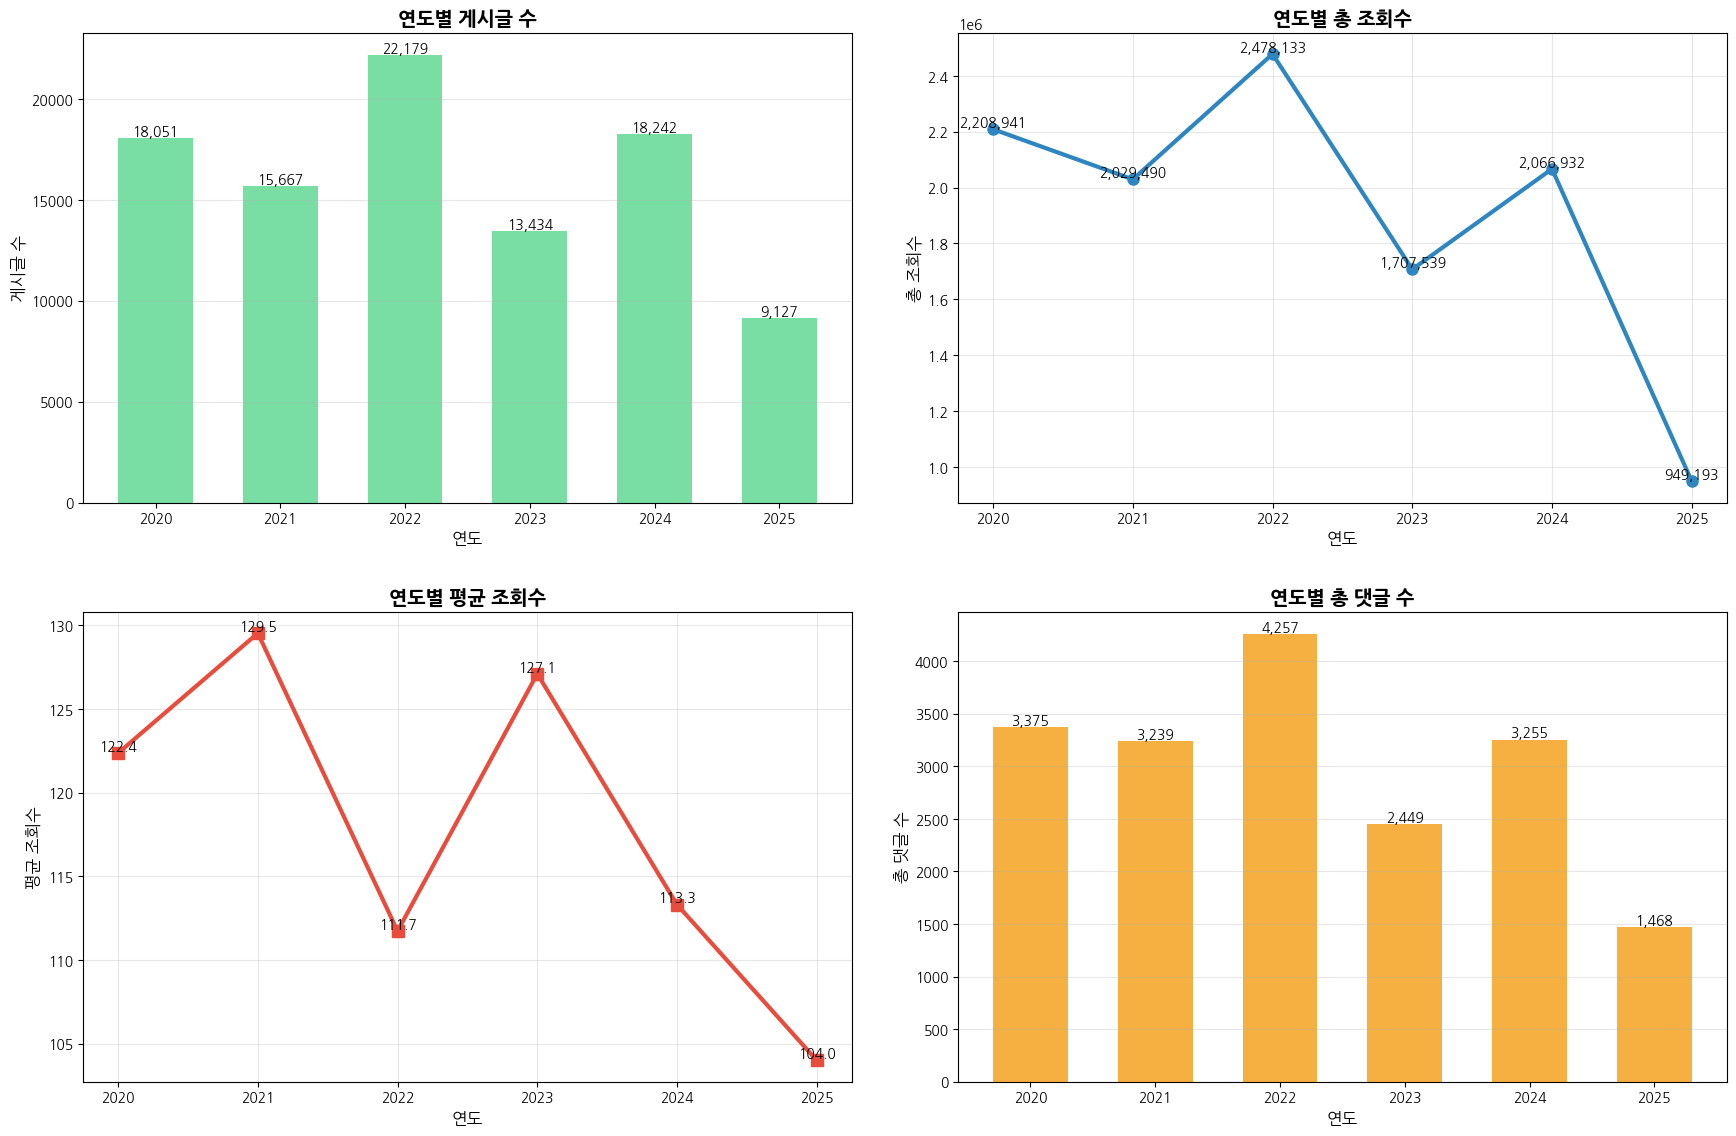


📅 월별 분석...
=== 월별 통계 ===
2020-01: 게시글 4,474개, 총조회수 581,761, 평균조회수 130.0
2020-02: 게시글 4,270개, 총조회수 532,485, 평균조회수 124.7
2020-03: 게시글 6,021개, 총조회수 717,413, 평균조회수 119.2
2020-04: 게시글 3,286개, 총조회수 377,282, 평균조회수 114.8
2021-02: 게시글 13개, 총조회수 1,196, 평균조회수 92.0
2021-05: 게시글 500개, 총조회수 51,774, 평균조회수 103.5
2021-06: 게시글 2,503개, 총조회수 320,019, 평균조회수 127.8
2021-07: 게시글 1,924개, 총조회수 210,616, 평균조회수 109.5
2021-08: 게시글 2,389개, 총조회수 302,818, 평균조회수 126.8
2021-09: 게시글 2,063개, 총조회수 271,937, 평균조회수 131.8
2021-10: 게시글 2,151개, 총조회수 316,107, 평균조회수 147.0
2021-11: 게시글 1,978개, 총조회수 261,018, 평균조회수 132.0
2021-12: 게시글 2,146개, 총조회수 294,005, 평균조회수 137.0
2022-01: 게시글 2,153개, 총조회수 277,008, 평균조회수 128.7
2022-02: 게시글 1,884개, 총조회수 206,569, 평균조회수 109.6
2022-03: 게시글 2,130개, 총조회수 215,434, 평균조회수 101.1
2022-04: 게시글 2,261개, 총조회수 210,106, 평균조회수 92.9
2022-05: 게시글 2,690개, 총조회수 400,064, 평균조회수 148.7
2022-06: 게시글 2,313개, 총조회수 218,626, 평균조회수 94.5
2022-07: 게시글 2,098개, 총조회수 189,932, 평균조회수 90.5
2022-08: 게시글 1,582개, 총조회수 164,389, 평균조회수 103.9

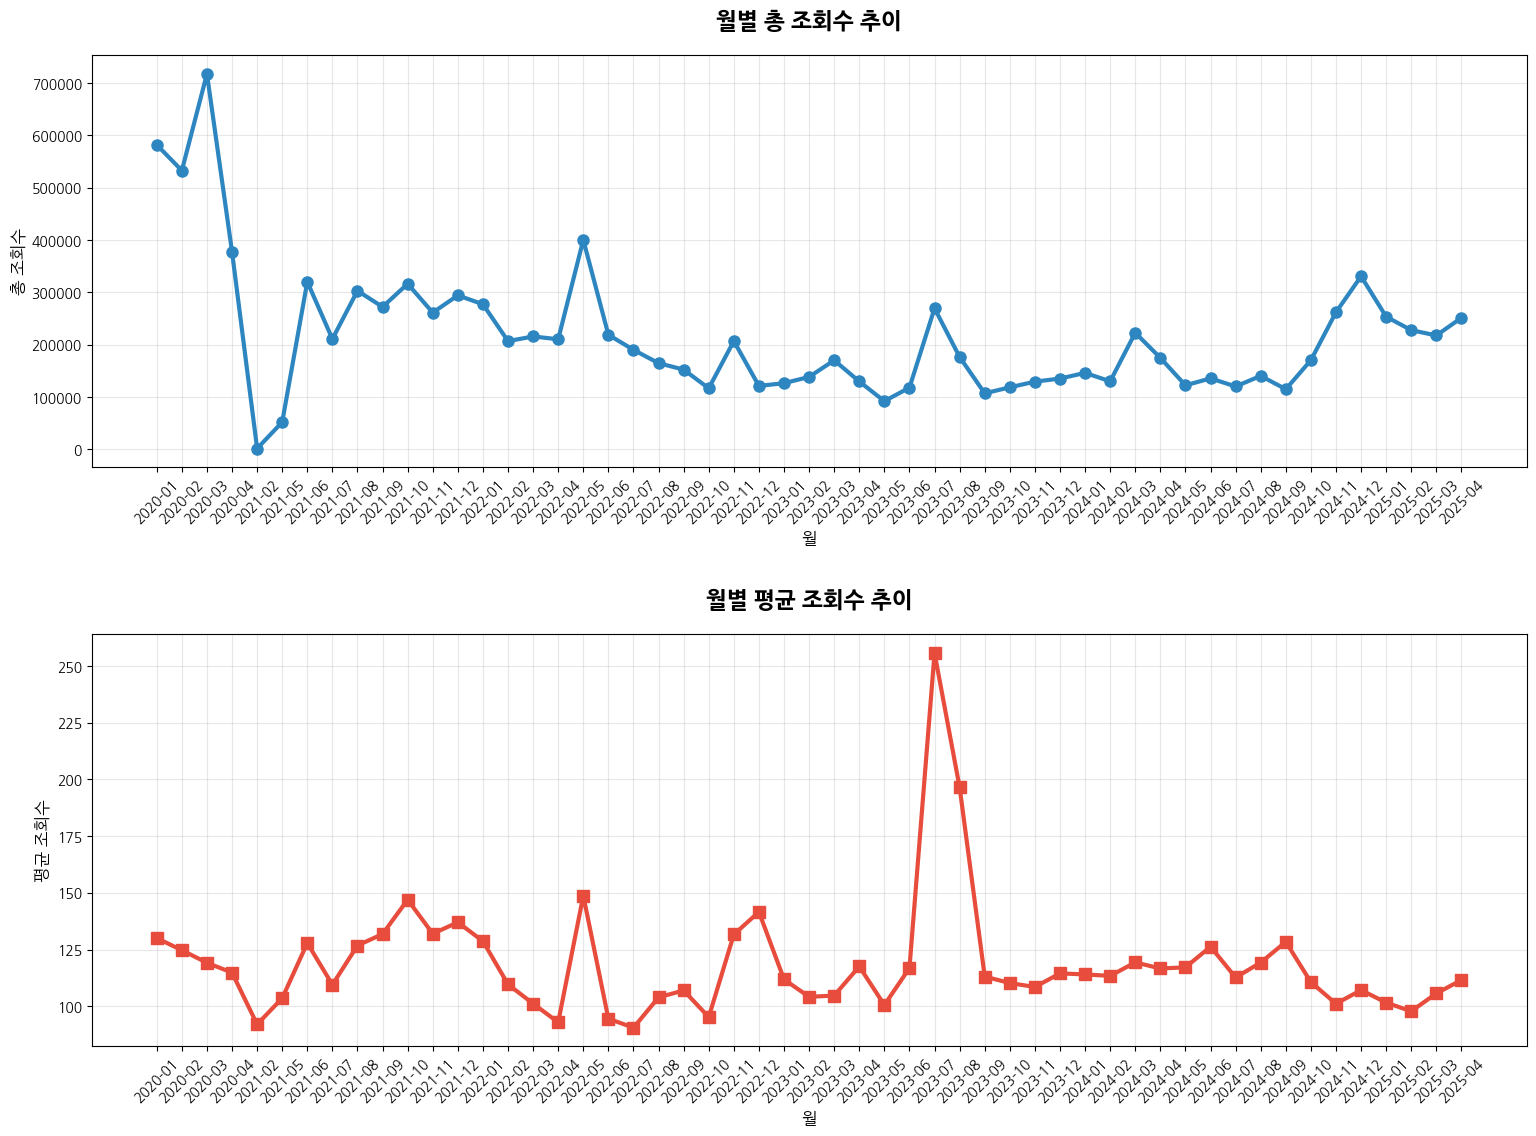

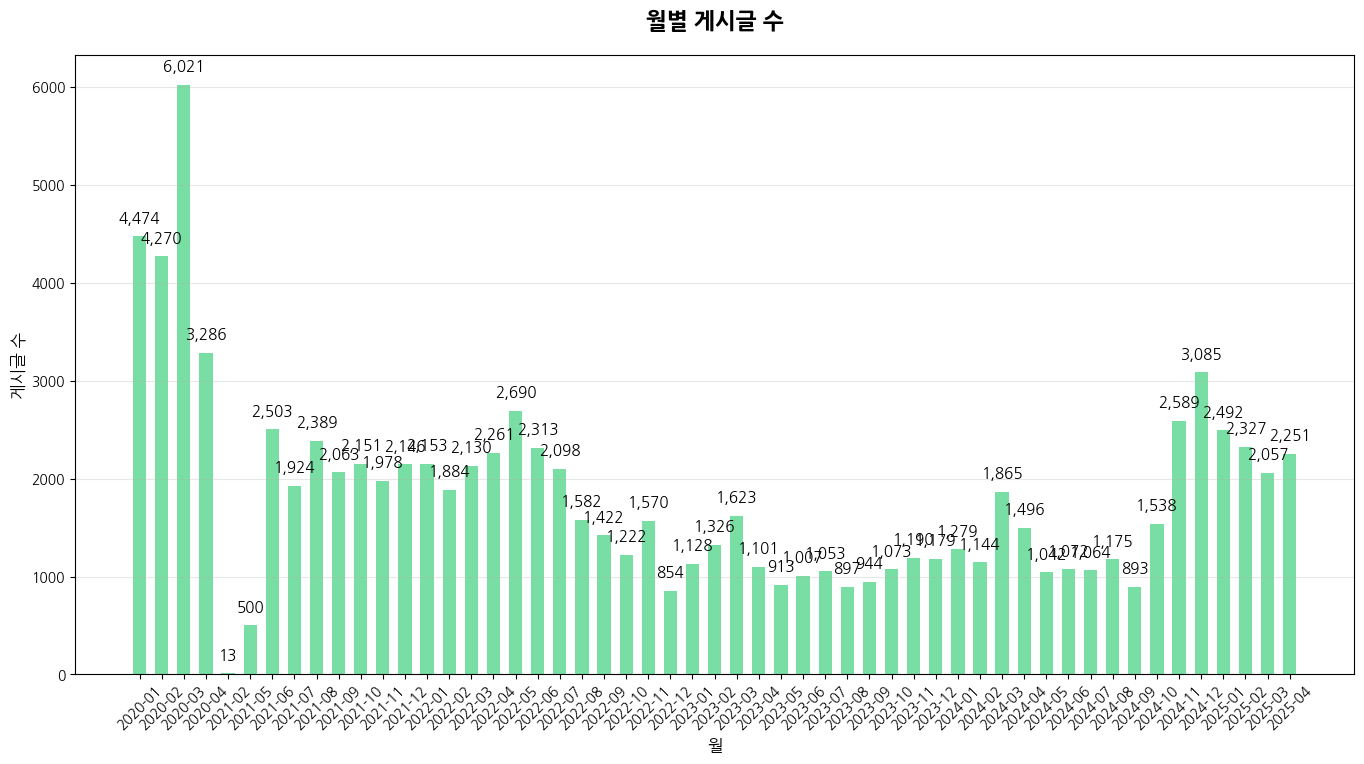


📈 주간별 분석...
=== 주간별 통계 (전체 225주) ===
첫 주차: 2019-12-30/2020-01-05
마지막 주차: 2025-04-28/2025-05-04
주간 평균 게시글수: 429.8개
주간 최대 게시글수: 2326개
주간 평균 총조회수: 50845


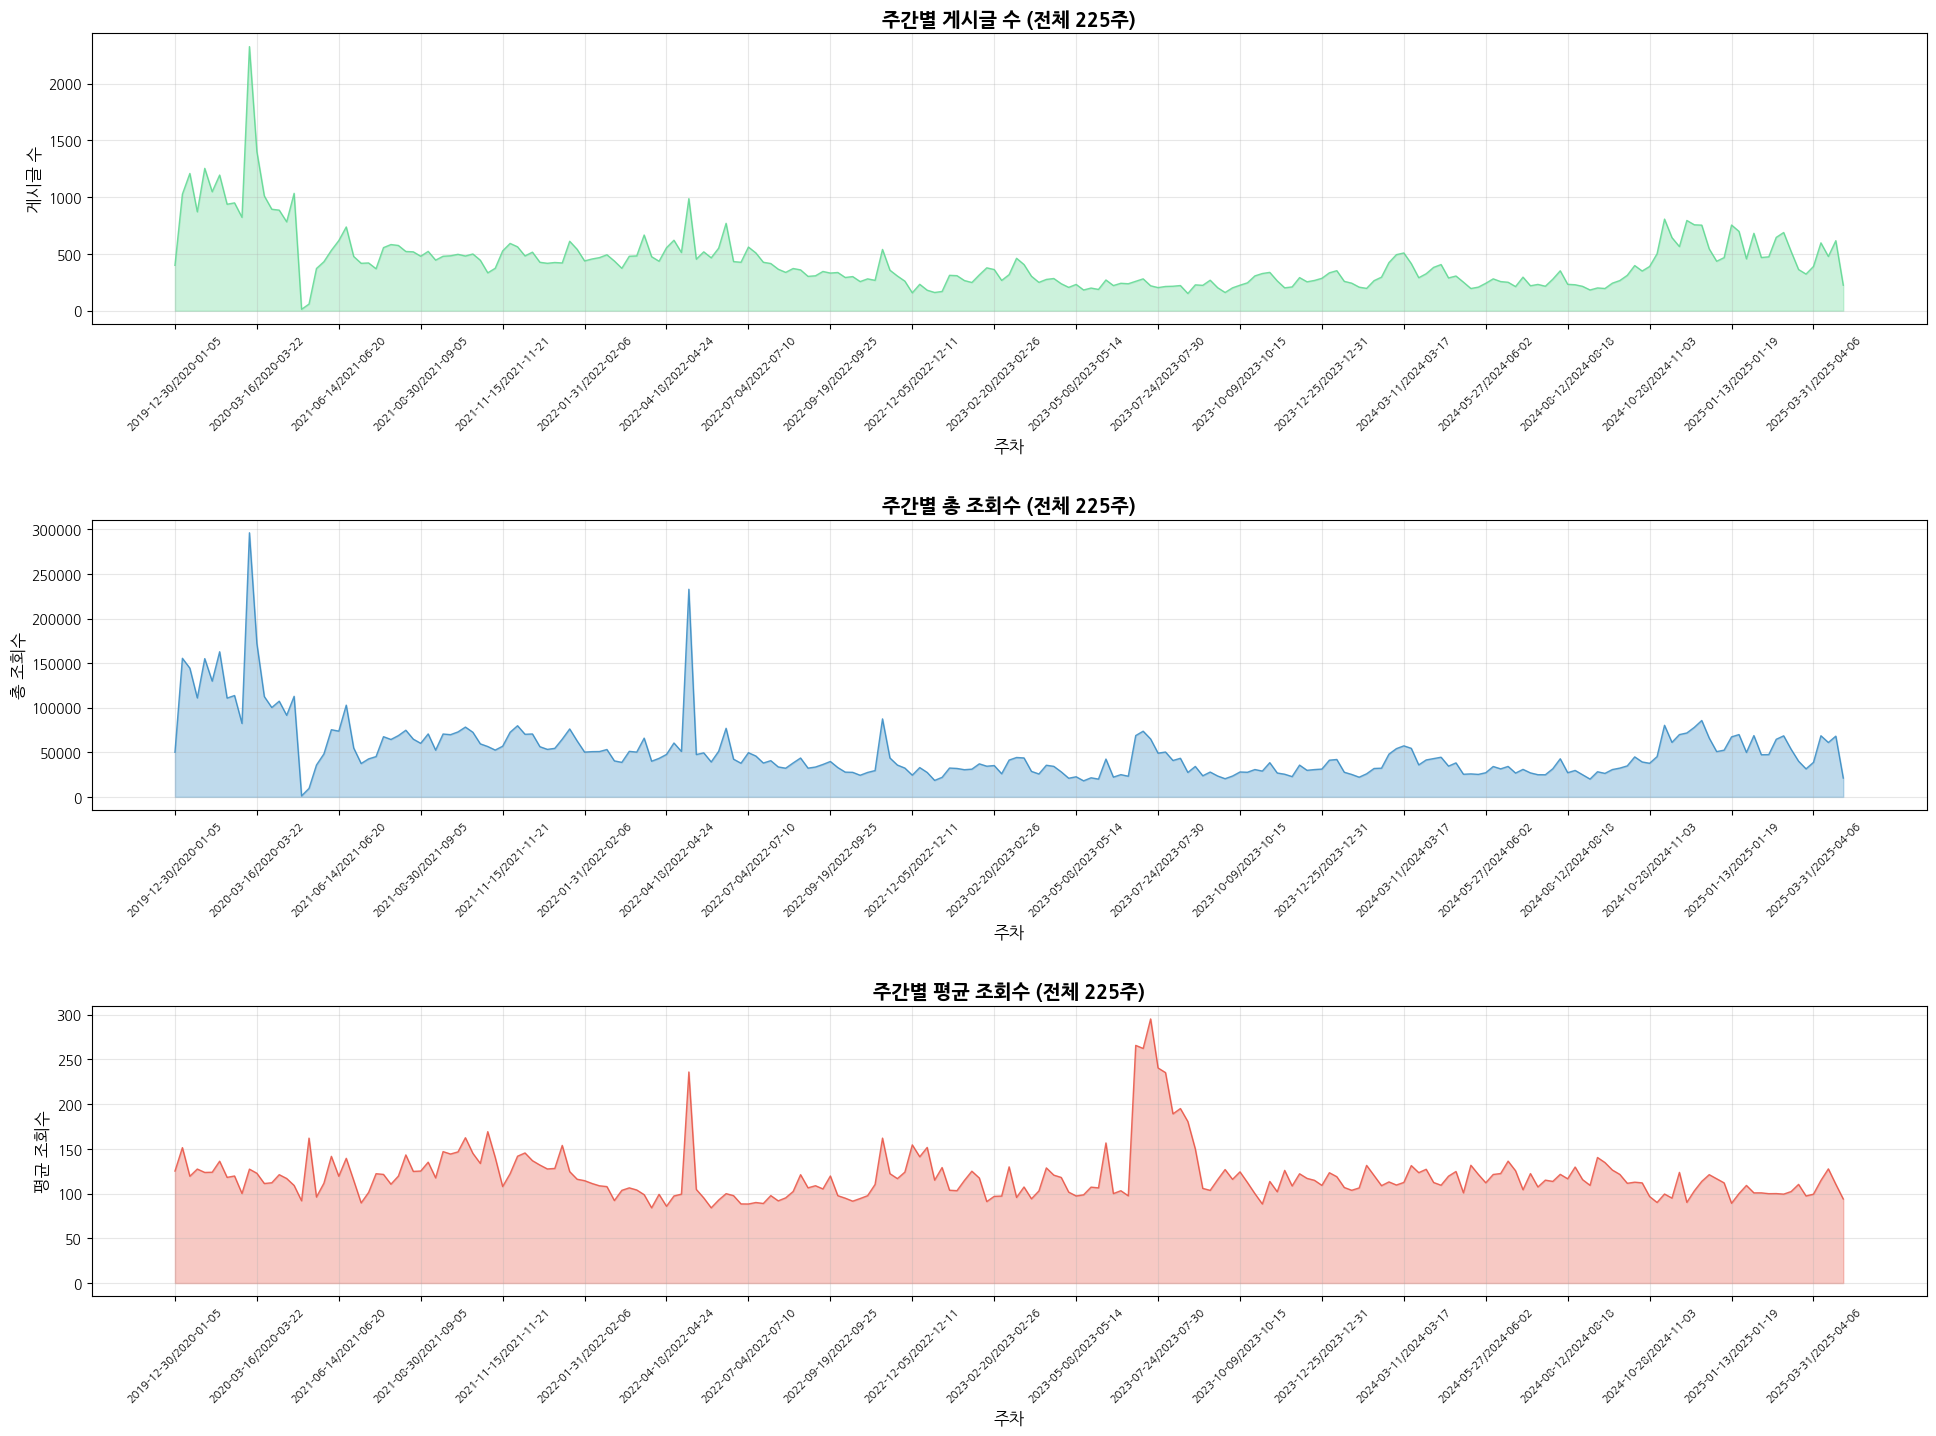


=== 주간별 데이터 요약 ===
총 주차 수: 225주
주간 게시글 수 - 평균: 429.8, 최소: 13, 최대: 2326
주간 총조회수 - 평균: 50845, 최소: 1196, 최대: 296309
주간 평균조회수 - 평균: 119.4, 최소: 84.1, 최대: 295.3

🔤 시간별 단어 빈도 분석
📅 연도별 단어 빈도 분석...
=== 2020년 가장 많이 사용된 단어 TOP 20 ===
 1. 비트: 1,960회
 2. 차트: 780회
 3. 사람: 685회
 4. 청산: 678회
 5. 존나: 643회
 6. 하락: 642회
 7. 새끼: 616회
 8. 비트코인: 614회
 9. 시발: 592회
10. 상승: 580회
11. 반등: 542회
12. 씨발: 521회
13. 6k: 517회
14. 코인: 508회
15. 알트: 476회
16. 나스닥: 469회
17. 이번: 456회
18. 매수: 423회
19. 한번: 407회
20. 보고: 378회

=== 2021년 가장 많이 사용된 단어 TOP 20 ===
 1. 비트: 1,825회
 2. 알트: 806회
 3. 코인: 763회
 4. 차트: 678회
 5. 사람: 513회
 6. 씨발: 503회
 7. 존나: 503회
 8. 시발: 495회
 9. 하락: 483회
10. 새끼: 465회
11. 반등: 465회
12. 상승: 445회
13. 청산: 419회
14. 시드: 403회
15. 현물: 358회
16. 이번: 348회
17. 한번: 338회
18. 매수: 326회
19. 선물: 325회
20. 비트코인: 322회

=== 2022년 가장 많이 사용된 단어 TOP 20 ===
 1. 비트: 2,730회
 2. 코인: 1,160회
 3. 알트: 970회
 4. usd: 750회
 5. 시발: 744회
 6. 존나: 734회
 7. 차트: 720회
 8. 사람: 717회
 9. 루나: 706회
10. 상승: 696회
11. 하락: 672회
12. 씨발: 644회
13. 새끼: 626회
14.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import koreanize_matplotlib
from difflib import SequenceMatcher

# 한국어 형태소 분석을 위한 라이브러리 (설치 필요)
try:
    from konlpy.tag import Okt, Mecab, Kkma
    KONLPY_AVAILABLE = True
    print("✅ KoNLPy 라이브러리가 사용 가능합니다.")
except ImportError:
    KONLPY_AVAILABLE = False
    print("⚠️ KoNLPy 라이브러리가 설치되지 않았습니다. 기본 분석을 사용합니다.")
    print("설치 방법: !pip install konlpy")

class AdvancedCommunityDataAnalyzer:
    def __init__(self, csv_file_path):
        """
        개선된 커뮤니티 데이터 분석기 초기화
        
        Args:
            csv_file_path (str): CSV 파일 경로
        """
        self.csv_file_path = csv_file_path
        self.df = None
        self.processed_df = None
        self.filtered_df = None  # 도배 필터링된 데이터
        
        # 한국어 형태소 분석기 초기화
        if KONLPY_AVAILABLE:
            try:
                self.okt = Okt()
                self.morphology_analyzer = self.okt
                self.use_morphology = True
                print("✅ Okt 형태소 분석기를 사용합니다.")
            except:
                self.use_morphology = False
                print("⚠️ 형태소 분석기 초기화 실패. 기본 분석을 사용합니다.")
        else:
            self.use_morphology = False
    
    def load_data(self):
        """CSV 파일을 로드하고 기본 정보를 출력"""
        try:
            self.df = pd.read_csv(self.csv_file_path, encoding='utf-8')
            print("=== 데이터 로드 완료 ===")
            print(f"총 데이터 수: {len(self.df):,}개")
            print(f"컬럼: {list(self.df.columns)}")
            print("\n=== 데이터 미리보기 ===")
            print(self.df.head())
            return True
        except Exception as e:
            print(f"데이터 로드 오류: {e}")
            return False
    
    def preprocess_data(self):
        """데이터 전처리"""
        if self.df is None:
            print("데이터를 먼저 로드해주세요.")
            return False
        
        # 데이터 복사
        self.processed_df = self.df.copy()
        
        # 날짜 변환 함수
        def convert_date_pandas(date_str):
            if pd.isna(date_str):
                return pd.NaT
            
            date_str = str(date_str)
            try:
                if '.' in date_str:
                    return pd.to_datetime(date_str, format='%y.%m.%d')
                elif '/' in date_str:
                    return pd.to_datetime(date_str, format='%y/%m/%d')
                else:
                    return pd.NaT
            except:
                return pd.NaT
        
        # 날짜 변환
        self.processed_df['날짜_변환'] = self.processed_df['날짜'].apply(convert_date_pandas)
        self.processed_df = self.processed_df.dropna(subset=['날짜_변환'])
        
        # 연도, 연월, 주차 컬럼 추가
        self.processed_df['연도'] = self.processed_df['날짜_변환'].dt.year
        self.processed_df['연월'] = self.processed_df['날짜_변환'].dt.to_period('M')
        self.processed_df['주차'] = self.processed_df['날짜_변환'].dt.to_period('W')
        
        # 숫자 컬럼 변환
        def safe_convert_to_numeric(x):
            try:
                if pd.isna(x) or x == '' or x == 'NaN':
                    return 0
                if isinstance(x, str):
                    clean_num = ''.join(filter(str.isdigit, str(x)))
                    return int(clean_num) if clean_num else 0
                return int(x)
            except:
                return 0
        
        self.processed_df['조회수'] = self.processed_df['조회수'].apply(safe_convert_to_numeric)
        self.processed_df['댓글갯수'] = self.processed_df['댓글갯수'].apply(safe_convert_to_numeric)
        
        # 결측값 처리
        self.processed_df['제목'] = self.processed_df['제목'].fillna("")
        self.processed_df['내용'] = self.processed_df['내용'].fillna("")
        
        print("=== 데이터 전처리 완료 ===")
        print(f"처리된 데이터 수: {len(self.processed_df):,}개")
        
        return True
    
    def calculate_text_similarity(self, text1, text2):
        """두 텍스트 간의 유사도 계산 (0~1)"""
        return SequenceMatcher(None, text1, text2).ratio()
    
    def detect_spam_posts_exact_only(self, use_hashing=True):
        """
        완전히 똑같은 글만 중복으로 처리 (가장 보수적)
        
        Args:
            use_hashing (bool): 해시 기반 빠른 필터링 사용 여부
        """
        if self.processed_df is None:
            print("데이터를 먼저 전처리해주세요.")
            return
        
        print("=== 완전 동일한 중복 게시글만 탐지 ===")
        print(f"📊 총 {len(self.processed_df):,}개 게시글 분석")
        print("🔍 글자 하나라도 다르면 다른 글로 인정합니다")
        
        spam_indices = set()
        
        if use_hashing:
            # 해시 기반 완전 중복 탐지만 사용
            print("🚀 해시 기반 완전 중복 탐지...")
            title_hashes = {}
            content_hashes = {}
            combined_hashes = {}  # 제목+내용 통합 해시
            
            for idx, row in self.processed_df.iterrows():
                # 공백 정규화 (연속된 공백을 하나로)
                title_clean = re.sub(r'\s+', ' ', str(row['제목']).strip())
                content_clean = re.sub(r'\s+', ' ', str(row['내용']).strip())
                combined_clean = title_clean + " | " + content_clean
                
                # 1. 제목 완전 중복 체크
                title_hash = hash(title_clean.lower())
                if title_hash in title_hashes:
                    spam_indices.add(idx)
                else:
                    title_hashes[title_hash] = idx
                
                # 2. 내용 완전 중복 체크 (3글자 이상인 경우만)
                if len(content_clean) >= 3:
                    content_hash = hash(content_clean.lower())
                    if content_hash in content_hashes:
                        spam_indices.add(idx)
                    else:
                        content_hashes[content_hash] = idx
                
                # 3. 제목+내용 통합 완전 중복 체크
                combined_hash = hash(combined_clean.lower())
                if combined_hash in combined_hashes:
                    spam_indices.add(idx)
                else:
                    combined_hashes[combined_hash] = idx
            
            print(f"   총 중복 발견: {len(spam_indices):,}개")
        
        # 중복이 아닌 게시글만 필터링
        self.filtered_df = self.processed_df[~self.processed_df.index.isin(spam_indices)].copy()
        
        print(f"\n=== 완전 동일 중복 필터링 결과 ===")
        print(f"원본 게시글 수: {len(self.processed_df):,}개")
        print(f"완전 동일 중복 수: {len(spam_indices):,}개 ({len(spam_indices)/len(self.processed_df)*100:.1f}%)")
        print(f"필터링 후 게시글 수: {len(self.filtered_df):,}개")
        print(f"✅ 글자 하나라도 다르면 별개 게시글로 유지됩니다!")
        
        return spam_indices
    
    def analyze_yearly_trends(self):
        """연도별 트렌드 분석"""
        if self.processed_df is None:
            print("데이터를 먼저 전처리해주세요.")
            return None
        
        # 연도별 통계 계산
        yearly_stats = self.processed_df.groupby('연도').agg({
            '번호': 'count',
            '조회수': ['sum', 'mean', 'max'],
            '댓글갯수': ['sum', 'mean']
        }).round(2)
        
        # 컬럼명 정리
        yearly_stats.columns = ['게시글수', '총조회수', '평균조회수', '최대조회수', '총댓글수', '평균댓글수']
        yearly_stats = yearly_stats.reset_index()
        
        print("=== 연도별 통계 ===")
        for _, row in yearly_stats.iterrows():
            print(f"{int(row['연도'])}: 게시글 {row['게시글수']:,}개, "
                  f"총조회수 {row['총조회수']:,.0f}, 평균조회수 {row['평균조회수']:.1f}")
        
        return yearly_stats
    
    def analyze_monthly_trends(self):
        """월별 트렌드 분석"""
        if self.processed_df is None:
            print("데이터를 먼저 전처리해주세요.")
            return None
        
        # 월별 통계 계산
        monthly_stats = self.processed_df.groupby('연월').agg({
            '번호': 'count',
            '조회수': ['sum', 'mean', 'max'],
            '댓글갯수': ['sum', 'mean']
        }).round(2)
        
        # 컬럼명 정리
        monthly_stats.columns = ['게시글수', '총조회수', '평균조회수', '최대조회수', '총댓글수', '평균댓글수']
        monthly_stats = monthly_stats.reset_index()
        monthly_stats['연월_str'] = monthly_stats['연월'].astype(str)
        
        print("=== 월별 통계 ===")
        for _, row in monthly_stats.iterrows():
            print(f"{row['연월_str']}: 게시글 {row['게시글수']:,}개, "
                  f"총조회수 {row['총조회수']:,.0f}, 평균조회수 {row['평균조회수']:.1f}")
        
        return monthly_stats
    
    def analyze_weekly_trends(self):
        """주간별 트렌드 분석 (전체 기간)"""
        if self.processed_df is None:
            print("데이터를 먼저 전처리해주세요.")
            return None
        
        # 주간별 통계 계산 (전체 기간)
        weekly_stats = self.processed_df.groupby('주차').agg({
            '번호': 'count',
            '조회수': ['sum', 'mean'],
            '댓글갯수': ['sum', 'mean']
        }).round(2)
        
        # 컬럼명 정리
        weekly_stats.columns = ['게시글수', '총조회수', '평균조회수', '총댓글수', '평균댓글수']
        weekly_stats = weekly_stats.reset_index()
        weekly_stats['주차_str'] = weekly_stats['주차'].astype(str)
        
        print(f"=== 주간별 통계 (전체 {len(weekly_stats)}주) ===")
        print(f"첫 주차: {weekly_stats['주차_str'].iloc[0]}")
        print(f"마지막 주차: {weekly_stats['주차_str'].iloc[-1]}")
        print(f"주간 평균 게시글수: {weekly_stats['게시글수'].mean():.1f}개")
        print(f"주간 최대 게시글수: {weekly_stats['게시글수'].max()}개")
        print(f"주간 평균 총조회수: {weekly_stats['총조회수'].mean():.0f}")
        
        return weekly_stats
    
    def plot_yearly_trends(self, yearly_stats):
        """연도별 트렌드 차트 그리기"""
        if yearly_stats is None:
            print("연도별 통계를 먼저 계산해주세요.")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
        
        # 연도별 게시글 수
        ax1.bar(yearly_stats['연도'], yearly_stats['게시글수'], 
                color='#58D68D', alpha=0.8, width=0.6)
        ax1.set_title('연도별 게시글 수', fontsize=14, fontweight='bold')
        ax1.set_xlabel('연도', fontsize=12)
        ax1.set_ylabel('게시글 수', fontsize=12)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # 값 표시
        for i, v in enumerate(yearly_stats['게시글수']):
            ax1.annotate(f'{v:,.0f}', (yearly_stats['연도'].iloc[i], v), 
                        ha='center', va='bottom', fontsize=10)
        
        # 연도별 총 조회수
        ax2.plot(yearly_stats['연도'], yearly_stats['총조회수'], 
                marker='o', linewidth=3, markersize=8, color='#2E86C1')
        ax2.set_title('연도별 총 조회수', fontsize=14, fontweight='bold')
        ax2.set_xlabel('연도', fontsize=12)
        ax2.set_ylabel('총 조회수', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # 값 표시
        for i, v in enumerate(yearly_stats['총조회수']):
            ax2.annotate(f'{v:,.0f}', (yearly_stats['연도'].iloc[i], v), 
                        ha='center', va='bottom', fontsize=10)
        
        # 연도별 평균 조회수
        ax3.plot(yearly_stats['연도'], yearly_stats['평균조회수'], 
                marker='s', linewidth=3, markersize=8, color='#E74C3C')
        ax3.set_title('연도별 평균 조회수', fontsize=14, fontweight='bold')
        ax3.set_xlabel('연도', fontsize=12)
        ax3.set_ylabel('평균 조회수', fontsize=12)
        ax3.grid(True, alpha=0.3)
        
        # 값 표시
        for i, v in enumerate(yearly_stats['평균조회수']):
            ax3.annotate(f'{v:.1f}', (yearly_stats['연도'].iloc[i], v), 
                        ha='center', va='bottom', fontsize=10)
        
        # 연도별 댓글 수
        ax4.bar(yearly_stats['연도'], yearly_stats['총댓글수'], 
                color='#F39C12', alpha=0.8, width=0.6)
        ax4.set_title('연도별 총 댓글 수', fontsize=14, fontweight='bold')
        ax4.set_xlabel('연도', fontsize=12)
        ax4.set_ylabel('총 댓글 수', fontsize=12)
        ax4.grid(True, alpha=0.3, axis='y')
        
        # 값 표시
        for i, v in enumerate(yearly_stats['총댓글수']):
            ax4.annotate(f'{v:,.0f}', (yearly_stats['연도'].iloc[i], v), 
                        ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    def plot_monthly_views(self, monthly_stats):
        """월별 조회수 차트 그리기 - 개선된 버전"""
        if monthly_stats is None:
            print("월별 통계를 먼저 계산해주세요.")
            return
        
        # 그래프 크기를 더 크게 설정
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
        
        # 총 조회수 추이
        ax1.plot(monthly_stats['연월_str'], monthly_stats['총조회수'], 
                marker='o', linewidth=3, markersize=8, color='#2E86C1')
        ax1.set_title('월별 총 조회수 추이', fontsize=16, fontweight='bold', pad=20)
        ax1.set_xlabel('월', fontsize=12)
        ax1.set_ylabel('총 조회수', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # X축 라벨 회전각 조정하고 간격 늘리기
        ax1.tick_params(axis='x', rotation=45, labelsize=10)
        ax1.tick_params(axis='y', labelsize=10)
        
        # 평균 조회수 추이
        ax2.plot(monthly_stats['연월_str'], monthly_stats['평균조회수'], 
                marker='s', linewidth=3, markersize=8, color='#E74C3C')
        ax2.set_title('월별 평균 조회수 추이', fontsize=16, fontweight='bold', pad=20)
        ax2.set_xlabel('월', fontsize=12)
        ax2.set_ylabel('평균 조회수', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # X축 라벨 회전각 조정
        ax2.tick_params(axis='x', rotation=45, labelsize=10)
        ax2.tick_params(axis='y', labelsize=10)
        
        # 여백 조정
        plt.tight_layout(pad=3.0)
        plt.show()
        
        # 게시글 수 차트 - 더 큰 크기로
        plt.figure(figsize=(14, 8))
        bars = plt.bar(monthly_stats['연월_str'], monthly_stats['게시글수'], 
                      color='#58D68D', alpha=0.8, width=0.6)
        plt.title('월별 게시글 수', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('월', fontsize=12)
        plt.ylabel('게시글 수', fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        
        # 값 표시 - 막대 위에 표시
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:,.0f}', 
                        xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 8), 
                        textcoords="offset points", 
                        ha='center', 
                        va='bottom',
                        fontsize=11)
        
        # X축 라벨 조정
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout(pad=2.0)
        plt.show()
    
    def plot_weekly_trends(self, weekly_stats):
        """주간별 트렌드 차트 그리기 (전체 기간)"""
        if weekly_stats is None:
            print("주간별 통계를 먼저 계산해주세요.")
            return
        
        # 전체 주차가 많을 경우를 대비해 x축 라벨 간격 조정
        total_weeks = len(weekly_stats)
        label_step = max(1, total_weeks // 20)  # 최대 20개 라벨만 표시
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15))
        
        # 주간별 게시글 수
        ax1.plot(range(len(weekly_stats)), weekly_stats['게시글수'], 
                linewidth=1, color='#58D68D', alpha=0.8)
        ax1.fill_between(range(len(weekly_stats)), weekly_stats['게시글수'], 
                        alpha=0.3, color='#58D68D')
        ax1.set_title(f'주간별 게시글 수 (전체 {total_weeks}주)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('주차', fontsize=12)
        ax1.set_ylabel('게시글 수', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # x축 라벨 간격 조정
        xtick_positions = range(0, len(weekly_stats), label_step)
        xtick_labels = [weekly_stats['주차_str'].iloc[i] for i in xtick_positions]
        ax1.set_xticks(xtick_positions)
        ax1.set_xticklabels(xtick_labels, rotation=45, fontsize=8)
        
        # 주간별 총 조회수
        ax2.plot(range(len(weekly_stats)), weekly_stats['총조회수'], 
                linewidth=1, color='#2E86C1', alpha=0.8)
        ax2.fill_between(range(len(weekly_stats)), weekly_stats['총조회수'], 
                        alpha=0.3, color='#2E86C1')
        ax2.set_title(f'주간별 총 조회수 (전체 {total_weeks}주)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('주차', fontsize=12)
        ax2.set_ylabel('총 조회수', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_xticks(xtick_positions)
        ax2.set_xticklabels(xtick_labels, rotation=45, fontsize=8)
        
        # 주간별 평균 조회수
        ax3.plot(range(len(weekly_stats)), weekly_stats['평균조회수'], 
                linewidth=1, color='#E74C3C', alpha=0.8)
        ax3.fill_between(range(len(weekly_stats)), weekly_stats['평균조회수'], 
                        alpha=0.3, color='#E74C3C')
        ax3.set_title(f'주간별 평균 조회수 (전체 {total_weeks}주)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('주차', fontsize=12)
        ax3.set_ylabel('평균 조회수', fontsize=12)
        ax3.grid(True, alpha=0.3)
        ax3.set_xticks(xtick_positions)
        ax3.set_xticklabels(xtick_labels, rotation=45, fontsize=8)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        # 주간별 통계 요약 출력
        print(f"\n=== 주간별 데이터 요약 ===")
        print(f"총 주차 수: {total_weeks}주")
        print(f"주간 게시글 수 - 평균: {weekly_stats['게시글수'].mean():.1f}, 최소: {weekly_stats['게시글수'].min()}, 최대: {weekly_stats['게시글수'].max()}")
        print(f"주간 총조회수 - 평균: {weekly_stats['총조회수'].mean():.0f}, 최소: {weekly_stats['총조회수'].min():.0f}, 최대: {weekly_stats['총조회수'].max():.0f}")
        print(f"주간 평균조회수 - 평균: {weekly_stats['평균조회수'].mean():.1f}, 최소: {weekly_stats['평균조회수'].min():.1f}, 최대: {weekly_stats['평균조회수'].max():.1f}")
    
    def extract_korean_morphemes(self, text, extract_nouns=True, extract_verbs=False, extract_adjectives=False):
        """
        한국어 형태소 분석을 통한 단어 추출
        
        Args:
            text (str): 분석할 텍스트
            extract_nouns (bool): 명사 추출 여부
            extract_verbs (bool): 동사 추출 여부  
            extract_adjectives (bool): 형용사 추출 여부
        """
        if not self.use_morphology:
            return []
        
        try:
            # 형태소 분석
            morphemes = self.morphology_analyzer.pos(text, stem=True)
            
            extracted_words = []
            for word, pos in morphemes:
                # 2글자 이상만 추출
                if len(word) < 2:
                    continue
                    
                # 품사별 추출
                if extract_nouns and pos.startswith('N'):  # 명사
                    extracted_words.append(word)
                elif extract_verbs and pos.startswith('V'):  # 동사
                    extracted_words.append(word)
                elif extract_adjectives and pos.startswith('A'):  # 형용사
                    extracted_words.append(word)
            
            return extracted_words
            
        except Exception as e:
            print(f"형태소 분석 오류: {e}")
            return []
    
    def _get_filtered_words_advanced(self, text, use_morphology=True):
        """
        개선된 단어 필터링 (형태소 분석 + 기존 방식)
        """
        # 한국어 형태소 분석 사용
        if use_morphology and self.use_morphology:
            korean_words = self.extract_korean_morphemes(
                text, 
                extract_nouns=True, 
                extract_verbs=False,  # 동사는 제외 (의미가 모호할 수 있음)
                extract_adjectives=False  # 형용사도 제외
            )
        else:
            # 기존 방식: 정규식으로 한글 단어 추출
            korean_words = re.findall(r'[가-힣]{2,}', text)
        
        # 영어/숫자 단어 추출
        english_words = re.findall(r'[a-zA-Z0-9]{2,}', text.lower())
        
        # 모든 단어 합치기
        all_words = korean_words + english_words
        
        # 확장된 불용어 목록
        stop_words = {
            # 기존 불용어들...
            '이거', '이건', '저거', '저건', '그거', '그건', '여기', '저기', '거기',
            '이게', '저게', '그게', '이야', '저야', '그야', '이런', '저런', '그런',
            '뭐야', '뭔가', '진짜', '정말', '완전', '아니', '그냥', '좀', '더', 
            '너무', '되게', '엄청', '완전히', '정말로', '진짜로', '되면', '하지만',
            '근데', '그런데', '그리고', '또한', '그래서', '따라서', '그러나', 
            '그렇지만', '그러므로', '말고', '해서', '되고', '하고', '있고', '없고',
            '이제', '지금', '오늘', '어제', '내일', '요즘', '최근', '언제', '바로',
            '내용', '없음', '경우', '때문', '되는', '하는', '있는', '없는',
            '이렇게', '저렇게', '그렇게', '어떻게', '왜냐', '때문에', '이라고',
            '내가', '나는', '너는', '너가', '걔는', '걔가', '쟤는', '쟤가',
            '우리는', '우리가', '저는', '저가', '그가', '그는', '그녀는', '그녀가',
            
            # 커뮤니티 특화 불용어
            '게시글', '댓글', '조회수', '추천', '비추천', '신고', '수정', '삭제',
            '작성자', '닉네임', '아이디', '회원', '등급', '포인트', '게시판',
            'dc', 'official', 'app', '다시', '계속', '여기서', '많이', '제발', 'name',
            
            # 형태소 분석 결과 자주 나오는 불용어
            '것', '수', '때', '곳', '점', '번', '개', '명', '년', '월', '일',
            '시간', '분', '초', '정도', '만큼', '이상', '이하', '사이', '중',
            '안', '밖', '위', '아래', '앞', '뒤', '옆', '다음', '이전', '마지막',
            '처음', '끝', '시작', '종료', '완료', '시도', '노력', '생각', '의견',
            '문제', '해결', '상황', '상태', '결과', '과정', '방법', '방식',
            
            # 감정 표현 (너무 일반적인 것들)
            '좋다', '나쁘다', '싫다', '좋아', '싫어', '재미', '재밌', 'boring',
            '웃음', '슬픔', '기쁨', '화남', '놀람', '걱정', '불안', '안심'
        }
        
        # 불용어 제거 및 추가 필터링
        filtered_words = []
        for word in all_words:
            # 불용어 제거
            if word in stop_words:
                continue
            
            # 숫자만 있는 단어 제거
            if word.isdigit():
                continue
            
            # 반복 문자 제거 (ㅋㅋㅋ, ㅎㅎㅎ 등)
            if len(set(word)) == 1 and len(word) > 2:
                continue
            
            # 의성어/의태어 패턴 제거
            if re.match(r'^(.{1,2})\1+$', word):
                continue
            
            # 특수 패턴 제거 (URL 조각, 이메일 조각 등)
            if re.match(r'^(www|http|com|net|org)$', word):
                continue
                
            filtered_words.append(word)
        
        return filtered_words
    
    def analyze_text_frequency_advanced(self, top_n=30, use_filtered_data=True, use_morphology=True):
        """
        개선된 텍스트 빈도 분석
        
        Args:
            top_n (int): 상위 N개 단어
            use_filtered_data (bool): 도배 필터링된 데이터 사용 여부
            use_morphology (bool): 형태소 분석 사용 여부
        """
        # 사용할 데이터 선택
        if use_filtered_data and self.filtered_df is not None:
            data_to_use = self.filtered_df
            data_desc = "도배 필터링 후"
        else:
            data_to_use = self.processed_df
            data_desc = "전체"
        
        if data_to_use is None:
            print("데이터를 먼저 전처리해주세요.")
            return None
        
        # 모든 텍스트 합치기
        all_text = (data_to_use['제목'] + ' ' + data_to_use['내용']).str.cat(sep=' ')
        
        # 개선된 단어 추출
        final_words = self._get_filtered_words_advanced(all_text, use_morphology)
        
        # 빈도 계산
        word_freq = Counter(final_words)
        top_words = word_freq.most_common(top_n)
        
        morphology_desc = "형태소 분석" if (use_morphology and self.use_morphology) else "정규식"
        print(f"=== {data_desc} 데이터 단어 빈도 TOP {top_n} ({morphology_desc}) ===")
        for i, (word, count) in enumerate(top_words, 1):
            print(f"{i:2d}. {word}: {count:,}회")
        
        return top_words
    
    def analyze_yearly_word_frequency(self, top_n=20):
        """연도별 단어 빈도 분석"""
        if self.processed_df is None:
            print("데이터를 먼저 전처리해주세요.")
            return None
        
        yearly_word_freq = {}
        
        for year in sorted(self.processed_df['연도'].unique()):
            year_data = self.processed_df[self.processed_df['연도'] == year]
            
            # 해당 연도의 모든 텍스트 합치기
            year_text = (year_data['제목'] + ' ' + year_data['내용']).str.cat(sep=' ')
            
            # 필터링된 단어 가져오기
            year_words = self._get_filtered_words_advanced(year_text, use_morphology=self.use_morphology)
            
            # 빈도 계산
            word_freq = Counter(year_words)
            top_words = word_freq.most_common(top_n)
            yearly_word_freq[year] = top_words
            
            print(f"=== {year}년 가장 많이 사용된 단어 TOP {top_n} ===")
            for i, (word, count) in enumerate(top_words, 1):
                print(f"{i:2d}. {word}: {count:,}회")
            print()
        
        return yearly_word_freq
    
    def analyze_monthly_word_frequency(self, top_n=20):
        """월별 단어 빈도 분석"""
        if self.processed_df is None:
            print("데이터를 먼저 전처리해주세요.")
            return None
        
        monthly_word_freq = {}
        
        for month in sorted(self.processed_df['연월'].unique()):
            month_data = self.processed_df[self.processed_df['연월'] == month]
            
            # 해당 월의 모든 텍스트 합치기
            month_text = (month_data['제목'] + ' ' + month_data['내용']).str.cat(sep=' ')
            
            # 필터링된 단어 가져오기
            month_words = self._get_filtered_words_advanced(month_text, use_morphology=self.use_morphology)
            
            # 빈도 계산
            word_freq = Counter(month_words)
            top_words = word_freq.most_common(top_n)
            monthly_word_freq[month] = top_words
            
            print(f"=== {month} 가장 많이 사용된 단어 TOP {top_n} ===")
            for i, (word, count) in enumerate(top_words, 1):
                print(f"{i:2d}. {word}: {count:,}회")
            print()
        
        return monthly_word_freq
    
    def analyze_weekly_word_frequency(self, top_n=20):
        """주간별 단어 빈도 분석 (최근 20주만)"""
        if self.processed_df is None:
            print("데이터를 먼저 전처리해주세요.")
            return None
        
        weekly_word_freq = {}
        
        # 최근 20주만 분석 (전체 주차가 너무 많을 수 있음)
        recent_weeks = sorted(self.processed_df['주차'].unique())[-20:]
        
        for week in recent_weeks:
            week_data = self.processed_df[self.processed_df['주차'] == week]
            
            # 해당 주의 모든 텍스트 합치기
            week_text = (week_data['제목'] + ' ' + week_data['내용']).str.cat(sep=' ')
            
            # 필터링된 단어 가져오기
            week_words = self._get_filtered_words_advanced(week_text, use_morphology=self.use_morphology)
            
            # 빈도 계산
            word_freq = Counter(week_words)
            top_words = word_freq.most_common(top_n)
            weekly_word_freq[week] = top_words
            
            print(f"=== {week} 가장 많이 사용된 단어 TOP {top_n} ===")
            for i, (word, count) in enumerate(top_words, 1):
                print(f"{i:2d}. {word}: {count:,}회")
            print()
        
        return weekly_word_freq
    
    def plot_yearly_word_frequency(self, yearly_word_freq, top_n=10):
        """연도별 단어 빈도 차트 그리기"""
        if not yearly_word_freq:
            print("연도별 단어 빈도 데이터가 없습니다.")
            return
        
        years = sorted(yearly_word_freq.keys())
        num_years = len(years)
        
        # 서브플롯 구성 (2열로 배치)
        cols = 2
        rows = (num_years + 1) // 2
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
        if rows == 1:
            axes = [axes] if num_years == 1 else axes
        else:
            axes = axes.flatten()
        
        for i, year in enumerate(years):
            words, counts = zip(*yearly_word_freq[year][:top_n])
            
            ax = axes[i]
            y_pos = np.arange(len(words))
            
            bars = ax.barh(y_pos, counts, color='#3498DB', alpha=0.8, height=0.7)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(words, fontsize=10)
            ax.set_xlabel('빈도수', fontsize=11)
            ax.set_title(f'{year}년 단어 빈도 TOP {top_n}', fontsize=14, fontweight='bold')
            ax.invert_yaxis()
            ax.grid(True, alpha=0.3, axis='x')
            
            # 값 표시
            for j, bar in enumerate(bars):
                width = bar.get_width()
                ax.annotate(f'{width:,}', 
                           xy=(width, bar.get_y() + bar.get_height()/2),
                           xytext=(5, 0), 
                           textcoords="offset points", 
                           ha='left', 
                           va='center', 
                           fontsize=9)
        
        # 사용하지 않는 서브플롯 숨기기
        for i in range(num_years, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    def plot_monthly_word_frequency(self, monthly_word_freq, top_n=10, months_per_page=6):
        """월별 단어 빈도 차트 그리기 (페이지 나누기)"""
        if not monthly_word_freq:
            print("월별 단어 빈도 데이터가 없습니다.")
            return
        
        months = sorted(monthly_word_freq.keys())
        total_months = len(months)
        
        # 페이지별로 나누어 그리기
        for page_start in range(0, total_months, months_per_page):
            page_end = min(page_start + months_per_page, total_months)
            page_months = months[page_start:page_end]
            
            # 서브플롯 구성
            cols = 3
            rows = (len(page_months) + 2) // 3
            
            fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
            if rows == 1:
                axes = [axes] if len(page_months) == 1 else axes
            else:
                axes = axes.flatten()
            
            for i, month in enumerate(page_months):
                words, counts = zip(*monthly_word_freq[month][:top_n])
                
                ax = axes[i]
                y_pos = np.arange(len(words))
                
                bars = ax.barh(y_pos, counts, color='#E74C3C', alpha=0.8, height=0.7)
                ax.set_yticks(y_pos)
                ax.set_yticklabels(words, fontsize=9)
                ax.set_xlabel('빈도수', fontsize=10)
                ax.set_title(f'{month} 단어 빈도 TOP {top_n}', fontsize=12, fontweight='bold')
                ax.invert_yaxis()
                ax.grid(True, alpha=0.3, axis='x')
                
                # 값 표시
                for j, bar in enumerate(bars):
                    width = bar.get_width()
                    ax.annotate(f'{width:,}', 
                               xy=(width, bar.get_y() + bar.get_height()/2),
                               xytext=(3, 0), 
                               textcoords="offset points", 
                               ha='left', 
                               va='center', 
                               fontsize=8)
            
            # 사용하지 않는 서브플롯 숨기기
            for i in range(len(page_months), len(axes)):
                axes[i].set_visible(False)
            
            plt.suptitle(f'월별 단어 빈도 분석 ({page_start//months_per_page + 1}페이지)', 
                        fontsize=16, fontweight='bold')
            plt.tight_layout(pad=2.0)
            plt.show()
    
    def generate_advanced_summary_report(self):
        """개선된 종합 분석 리포트"""
        print("=" * 60)
        print("           개선된 커뮤니티 데이터 분석 리포트")
        print("=" * 60)
        
        if self.processed_df is not None:
            print("📊 원본 데이터 통계")
            total_posts = len(self.processed_df)
            print(f"   총 게시글 수: {total_posts:,}개")
            print(f"   총 조회수: {self.processed_df['조회수'].sum():,}회")
            print(f"   평균 조회수: {self.processed_df['조회수'].mean():.1f}회")
        
        if self.filtered_df is not None:
            print("\n🧹 필터링 후 데이터 통계")
            filtered_posts = len(self.filtered_df)
            removed_posts = total_posts - filtered_posts
            print(f"   필터링 후 게시글 수: {filtered_posts:,}개")
            print(f"   제거된 게시글 수: {removed_posts:,}개 ({removed_posts/total_posts*100:.1f}%)")
            print(f"   필터링 후 총 조회수: {self.filtered_df['조회수'].sum():,}회")
            print(f"   필터링 후 평균 조회수: {self.filtered_df['조회수'].mean():.1f}회")
        
        if self.use_morphology:
            print(f"\n🔤 형태소 분석: ✅ 사용 가능 (KoNLPy)")
        else:
            print(f"\n🔤 형태소 분석: ❌ 사용 불가 (정규식 사용)")
        
        print("=" * 60)

def run_advanced_analysis():
    """개선된 분석 실행"""
    # 분석기 초기화 (파일 경로 수정 필요)
    analyzer = AdvancedCommunityDataAnalyzer('community/ChartAnalysis.csv')  # 실제 파일 경로로 수정하세요
    
    # 1. 데이터 로드 및 전처리
    if not analyzer.load_data():
        return
    if not analyzer.preprocess_data():
        return
    
    # 2. 완전 동일한 중복 게시글만 필터링
    print("\n" + "="*50)
    print("🚫 완전히 똑같은 중복 게시글만 필터링")
    print("="*50)
    spam_indices = analyzer.detect_spam_posts_exact_only(use_hashing=True)
    
    # 3. 시간별 트렌드 분석 (원래 기능들)
    print("\n" + "="*50)
    print("📅 시간별 트렌드 분석")
    print("="*50)
    
    # 3-1. 연도별 트렌드 분석 및 차트
    print("🗓️ 연도별 분석...")
    yearly_stats = analyzer.analyze_yearly_trends()
    if yearly_stats is not None:
        analyzer.plot_yearly_trends(yearly_stats)
    
    # 3-2. 월별 트렌드 분석 및 차트  
    print("\n📅 월별 분석...")
    monthly_stats = analyzer.analyze_monthly_trends()
    if monthly_stats is not None:
        analyzer.plot_monthly_views(monthly_stats)
    
    # 3-3. 주간별 트렌드 분석 및 차트
    print("\n📈 주간별 분석...")
    weekly_stats = analyzer.analyze_weekly_trends()
    if weekly_stats is not None:
        analyzer.plot_weekly_trends(weekly_stats)
    
    # 4. 시간별 단어 빈도 분석 (원래 기능들)
    print("\n" + "="*50)
    print("🔤 시간별 단어 빈도 분석")
    print("="*50)
    
    # 4-1. 연도별 단어 빈도 분석
    print("📅 연도별 단어 빈도 분석...")
    yearly_word_freq = analyzer.analyze_yearly_word_frequency(top_n=20)
    if yearly_word_freq:
        analyzer.plot_yearly_word_frequency(yearly_word_freq, top_n=15)
    
    # 4-2. 월별 단어 빈도 분석
    print("\n📅 월별 단어 빈도 분석...")
    monthly_word_freq = analyzer.analyze_monthly_word_frequency(top_n=20)
    if monthly_word_freq:
        analyzer.plot_monthly_word_frequency(monthly_word_freq, top_n=10, months_per_page=6)
    
    # 4-3. 주간별 단어 빈도 분석 (최근 20주)
    print("\n📈 주간별 단어 빈도 분석 (최근 20주)...")
    weekly_word_freq = analyzer.analyze_weekly_word_frequency(top_n=15)
    
    # 5. 전체 단어 빈도 분석
    print("\n" + "="*50)
    print("📝 전체 데이터 단어 빈도 분석")
    print("="*50)
    
    # 필터링된 데이터 분석 (형태소 분석)
    if analyzer.use_morphology:
        print("\n[형태소 분석 기반]")
        filtered_words_morph = analyzer.analyze_text_frequency_advanced(
            top_n=30, use_filtered_data=True, use_morphology=True
        )
    else:
        print("\n[정규식 기반]")
        filtered_words_regex = analyzer.analyze_text_frequency_advanced(
            top_n=30, use_filtered_data=True, use_morphology=False
        )
    
    # 6. 종합 리포트
    analyzer.generate_advanced_summary_report()


def quick_exact_duplicate_filter():
    """완전히 똑같은 중복 게시글만 필터링"""
    analyzer = AdvancedCommunityDataAnalyzer('community/ChartAnalysis.csv')  # 실제 파일 경로로 수정하세요
    
    if not analyzer.load_data() or not analyzer.preprocess_data():
        return
    
    # 완전 동일 중복만 필터링
    spam_indices = analyzer.detect_spam_posts_exact_only(use_hashing=True)
    
    # 필터링된 데이터를 CSV로 저장
    if analyzer.filtered_df is not None:
        output_filename = 'filtered_community_data.csv'
        analyzer.filtered_df.to_csv(output_filename, index=False, encoding='utf-8')
        print(f"\n✅ 필터링된 데이터가 '{output_filename}'로 저장되었습니다.")


def morphology_analysis_only():
    """형태소 분석만 수행"""
    analyzer = AdvancedCommunityDataAnalyzer('community/ChartAnalysis.csv')  # 실제 파일 경로로 수정하세요
    
    if not analyzer.load_data() or not analyzer.preprocess_data():
        return
    
    if not analyzer.use_morphology:
        print("❌ 형태소 분석 라이브러리가 없습니다.")
        print("설치 방법: !pip install konlpy")
        return
    
    print("🔤 형태소 분석 기반 단어 빈도 분석")
    
    # 명사만 추출
    morpheme_words = analyzer.analyze_text_frequency_advanced(
        top_n=30, use_filtered_data=False, use_morphology=True
    )
    
    # 시각화
    if morpheme_words:
        plt.figure(figsize=(14, 12))
        words, counts = zip(*morpheme_words[:25])
        y_pos = np.arange(len(words))
        
        bars = plt.barh(y_pos, counts, color='#9B59B6', alpha=0.8)
        plt.yticks(y_pos, words, fontsize=11)
        plt.xlabel('빈도수', fontsize=12)
        plt.title('형태소 분석 기반 단어 빈도 (명사)', fontsize=16, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3, axis='x')
        
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.annotate(f'{width:,}', xy=(width, bar.get_y() + bar.get_height()/2),
                       xytext=(5, 0), textcoords="offset points", 
                       ha='left', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()


print("🚀 개선된 커뮤니티 데이터 분석기")
print("="*50)
print("1. run_advanced_analysis() - 전체 분석")
print("2. quick_exact_duplicate_filter() - 완전 동일 중복만 필터링")  
print("3. morphology_analysis_only() - 형태소 분석만")
print("="*50)
print("💡 완전히 똑같은 글만 중복으로 처리합니다 (가장 보수적)")

# 파일 경로를 실제 경로로 수정한 후  실행하세요
run_advanced_analysis()